# Car accidents in the U.K.

Classifying fatal and minor car accidents. Dataset provides 251,832 incidents, and a range of features describing the driver, car type, weather condition, timing, and location of the accidents. Only features involving the car or driver will be used, as a way of determining which insurance policies should have elevated rates based on the prospective customer's applications, as they present a higher likeliness of severe car collisions.
___
Using machine learning models, the aim will be to predict with accuracy, and ideally strong recall scores, which combinations of features present the highest risk of car accidents being fatal. 

## importing

In [1]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn import svm, tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, r2_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
#from sklearn.metrics import plot_confusion_matrix
scaler = MinMaxScaler()
%matplotlib inline
import itertools
import pprint
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
# model diagnostics and confusion matrix
def model_report(model): 
    
    print('\nCross Validation Scoring:\n')
    
    train_score = model.score(X_train, y_train)
    print("train score: {:.4}%".format(train_score * 100))

    test_score = model.score(X_test, y_test)
    print("test score: {:.4}%".format(test_score * 100))

    cv_score = np.mean(cross_val_score(model, X, y, cv=3))
    print("cross val score: {:.4}%".format(cv_score * 100))

    false_positive_rate, true_positive_rate, thresholds = roc_curve(actuals, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("AUC  : {:.4}%\n".format(roc_auc * 100))
    

    print("\nClassification Report:")
    print(classification_report(actuals, predictions))
    
    print('\nConfusion matrix:'.format(accuracy_score))
    display(pd.DataFrame(confusion_matrix(y_test, predictions),
                 columns=['pred non', 'pred fatal'], index=['actual non', 'actual fatal']))
    
    
    # AUC plot
    plt.figure(figsize=(5, 4))
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [3]:
# plotting feature importances
def plot_feats(model):
    n_features = X.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), (X.columns.values)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

## eda

Looking at size and distribution of features, as well as data types and unique count. Large data size could mean cells take much longer to run, in which case it may be worth sampling a smaller, but substantial portion for further analysis, especially when constructing grid searches and models. 

Also, it will be important to evaluate the relevance of the features. As a vehicle insurance company, the weather conditions and time related data won't be included as part of the evaluation process. Only information that would be requested on a typical application will be included. So, primarily, information about the driver and vehicle are of importance and will be kept in mind for deciding which columns to exclude.

In [4]:
# Accident data
df = pd.read_csv('Accidents_categorical.csv')

In [5]:
df.shape

(251832, 33)

251,832 rows and 33 columns are going to cost a lot of time, using a random sample might be a good choice for now.

In [6]:
#temporarily taking % of data 
df = df.sample(frac=.2, random_state=3)

In [7]:
# assign 1 and 0 to fatal and slight accidents in preparation of further analysis
df["Accident_Severity"]= df['Accident_Severity'].replace("Fatal_Serious", 1)
df["Accident_Severity"]= df['Accident_Severity'].replace("Slight", 0)

In [8]:
# percent fatal
All = df.shape[0]
fatal = df[df['Accident_Severity'] == 1]
nonFatal = df[df['Accident_Severity'] == 0]

f = len(fatal)/All
nf = len(nonFatal)/All

print('fatal :',round(f*100),'%')
print('non Fatal :',round(nf*100),'%')

fatal : 75 %
non Fatal : 25 %


I was a little surprised to see that 1/4 of reported accidents resulted in fatalities, more so than I had expected. Although that is obviously unfortunate, a healthy amount of the target variable is probably a good thing when it comes to training the models.

## data prep

geographical spread of fatal and non fatal accidents:

In [9]:
## run if including latitude or longitude:

# graphing lat and long of accidents and dropping outliers

# fatal.plot(kind="scatter", x="Longitude", y="Latitude", alpha= 0.5, color='red')
# nonFatal.plot(kind='scatter', x='Longitude', y="Latitude", alpha=0.5)

#len(df[df.Latitude > 56.5])/len(df)
#df = df[df.Latitude < 56.5]

I'm seeing some outliers in the NW portion on the map, and it may be helpful to exclude them from the model fitting if they don't account for much of the dataset.

### eliminating unneeded features/ dimension reduction

Some features will be excluded, as they wouldn't be available in your typical car insurance application. Only those involving the driver, car, and location will be of use.

In [10]:
# list of columns 
df.columns

Index(['Accident_Index', 'Latitude', 'Longitude', 'Region',
       'Urban_or_Rural_Area', 'X1st_Road_Class', 'Driver_IMD_Decile',
       'Speed_limit', 'Road_Type', 'Road_Surface_Conditions', 'Weather',
       'High_Wind', 'Lights', 'Datetime', 'Year', 'Season', 'Month_of_Year',
       'Day_of_Month', 'Day_of_Week', 'Hour_of_Day', 'Number_of_Vehicles',
       'Age_of_Driver', 'Age_of_Vehicle', 'Junction_Detail',
       'Junction_Location', 'X1st_Point_of_Impact', 'Driver_Journey_Purpose',
       'Engine_CC', 'Propulsion_Code', 'Vehicle_Make', 'Vehicle_Category',
       'Vehicle_Manoeuvre', 'Accident_Severity'],
      dtype='object')

In [11]:
# What is Driver_IMD?
# socioeconomic inequalities

# *The Index of Multiple Deprivation (IMD) combines information from the seven
# domains to produce an overall relative measure of deprivation. The domains are
# combined using the following weights:*

#  Income Deprivation (22.5%)

#  Employment Deprivation (22.5%)

#  Education, Skills and Training Deprivation (13.5%)

#  Health Deprivation and Disability (13.5%)

#  Crime (9.3%)

#  Barriers to Housing and Services (9.3%)

#  Living Environment Deprivation (9.3%)

# https://www.gov.uk/government/statistics/english-indices-of-deprivation

In [12]:
# # ignore unless using 'time_of_day'
#reduce time of day to hour as opposed to minute and hour-( not neccessary since this will be excluded
# df['Hour_of_Day'] = df['Hour_of_Day'].apply(lambda x: round(x*24))
# #df['Hour_of_Day'].unique()

In [13]:
#dropping columns relating to time and weather or road conditions.
df.drop(columns= 
    [
        'Accident_Index','Datetime', 'Year'
        ,'Latitude', 'Longitude'
        ,'X1st_Road_Class'
      ,'Speed_limit'
        , 'Road_Type', 'Road_Surface_Conditions', 'Weather'
       ,'High_Wind', 'Lights', 'Season', 'Month_of_Year'
       ,'Day_of_Month','Day_of_Week','Hour_of_Day', 'Number_of_Vehicles'
        ,'Junction_Detail','Junction_Location','X1st_Point_of_Impact','Vehicle_Manoeuvre'
        #,'Propulsion_Code'
        #, 'Vehicle_Category'
        #,'Driver_Journey_Purpose'
        #,'Urban_or_Rural_Area'
        #, 'Engine_CC'
        ]
, axis=1, inplace=True)

In [14]:
# seperate fatal and not fatal
fatal = df[df['Accident_Severity'] == 1]
nonFatal = df[df['Accident_Severity'] == 0]

In [15]:
#pandas_profiling.ProfileReport(fatal)

In [16]:
#pandas_profiling.ProfileReport(nonFatal)

Notes:
- Higher driver age in fatal
- Older vehicles in fatal
- Driver_IMD_Decile higher in fatal

- Work commute or as work is common in both
- Lower engine CC in fatal
- Propulsion code similar
- More accidents occur in Urban areas overall, but accidents in Rural areas are more often fatal
- Unsurprisingly, motorcycle accidents are more often fatal
- Fords and Vauxhall are most common in accidents, but are more often not fatal


-make journey purpose either work/school or other
-drop Wales and Scotland?
-combine van/taxi/bus/minibus

In [17]:
# assign 1 and 0 to fatal and slight accidents in preparation of further analysis
df["Driver_Journey_Purpose"]= df['Driver_Journey_Purpose'].replace("Journey as part of work", 'work/school')
df["Driver_Journey_Purpose"]= df['Driver_Journey_Purpose'].replace("Commuting to/from work", 'work/school')
df["Driver_Journey_Purpose"]= df['Driver_Journey_Purpose'].replace("Taking pupil to/from school", 'work/school')
df["Driver_Journey_Purpose"]= df['Driver_Journey_Purpose'].replace("Pupil riding to/from school", 'work/school')

### correlations

Checking correlations between variables to make sure features aren't overly correlated with each other.  I'm particularly concerned with the 'region and urban_or_rural_area' relationship and the 'vehicle make and vehicle category' relationship.

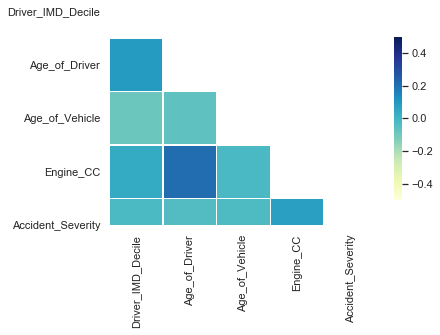

In [18]:
#corr plot
sns.set(style="white")
corr = df.corr()

#a mask the size of covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6,6))

sns.heatmap(corr, mask=mask, cmap="YlGnBu", vmin = -.5, vmax=.5, center=0,
            square=True
             ,linewidths=.5,
           cbar_kws= {"shrink": .5}
           );

Age of driver and engine CC show some correlation, but I don't see this as being problematic. 

___
Resampling is one way to get the target variables on the same scale for more meaningful comparisons and analysis. If there were less fatal accident data, I may have even generated synthetic fatal accident data for more robust models, but don't think that will be needed here.

In [19]:
#resampling for scaled visualizations
df1=df
df1 = resample(nonFatal, replace=True, n_samples=len(fatal))

df1 = pd.concat([fatal, df1])

 Region and Urban_or_Rural_Areas could potentially be too correlated,so we'll compare and possibly drop one to avoid causing bias when fitting to models.

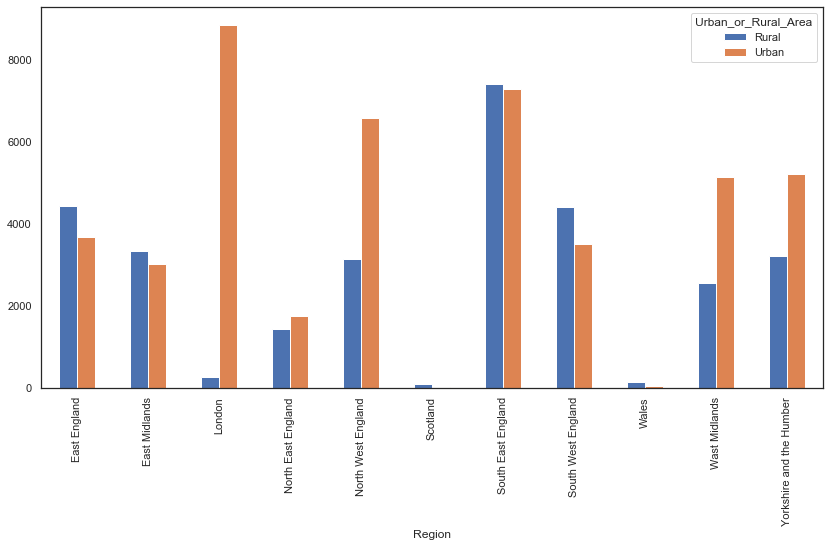

In [20]:
#correlation: region and urban or rural area
df1.groupby(['Region'])['Urban_or_Rural_Area'].value_counts().unstack().plot.bar(figsize=(14,7));

London and North West England do weigh heavily on the Urban side. Scotland and Wales hardly show any data, I feel pretty comfortable dropping them from the dataset. Another option would be to cluster them with nearby regions, something I might come back to later.

In [ ]:
# how much of dataset would be lost if excluding Scotland and Wales
(len(df[df.Region = 'Scotland'])+ len(df[df.Region = 'Wales']))/len(df)

In [21]:
# dropping scotland and wales
df = df[df.Region != 'Scotland']
df = df[df.Region != 'Wales']

___
Another concern is the potential correlation between Vehicle Category and Vehicle Make. Some Makes could exclusively produce one category of vehicle, in which case, using one feature or the other might be more practical, but I would like to avoid.

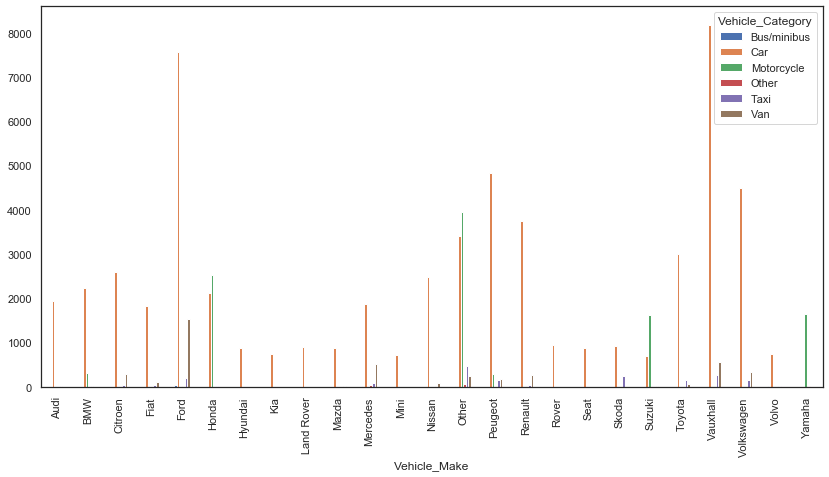

In [22]:
#correlations: vehicle make and vehicle category
df1.groupby(['Vehicle_Make'])['Vehicle_Category'].value_counts().unstack().plot.bar(figsize=(14,7));
#df1.groupby(['Vehicle_Category'])['Vehicle_Make'].value_counts().unstack().plot.bar(figsize=(14,7));

The vehicle type is dominantly 'car', and the category is very imbalanced with most makes. I don't think I'll make any alterations here, since I think this is important, although I may come back and handle this in a different way at some point.

In [23]:
# taxi/van/bus category due to low counts of those categories individually
df["Vehicle_Category"]= df['Vehicle_Category'].replace("Bus/minibus", 'taxi/van/bus')
df["Vehicle_Category"]= df['Vehicle_Category'].replace("Taxi", 'taxi/van/bus')
df["Vehicle_Category"]= df['Vehicle_Category'].replace("Van", 'taxi/van/bus')

___

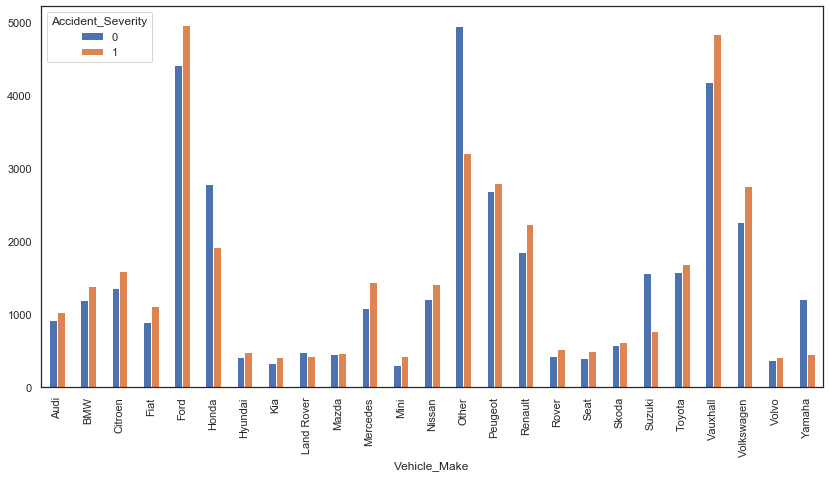

In [24]:
#vehicle makes and accident severity
df1.groupby(['Vehicle_Make'])['Accident_Severity'].value_counts().unstack().plot.bar(figsize=(14,7));

Yamaha and Suzuki show twice as many fatal accidents than non fatal, 

In [25]:
# ignore
# #region and accident severity
# df.groupby(['Region'])['Accident_Severity'].value_counts().unstack().plot.bar(figsize=(14,7));

# #value counts of region
# df.groupby(['Region'])['Accident_Severity'].value_counts().unstack()

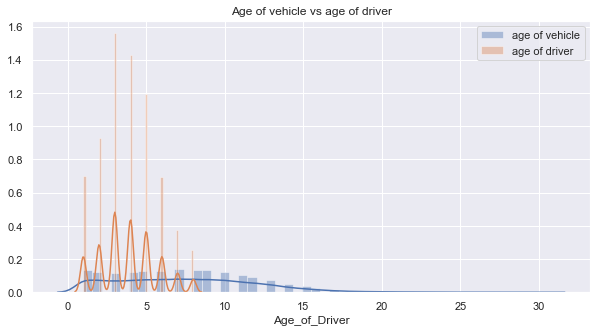

In [26]:
# engine cc and fatal/nonFatal
sns.set(rc={'figure.figsize':(10, 5)})
plt.title("Age of vehicle vs age of driver")
sns.distplot(df['Age_of_Vehicle'], label='age of vehicle') 
sns.distplot(df['Age_of_Driver'], label='age of driver')
plt.legend()
plt.show();

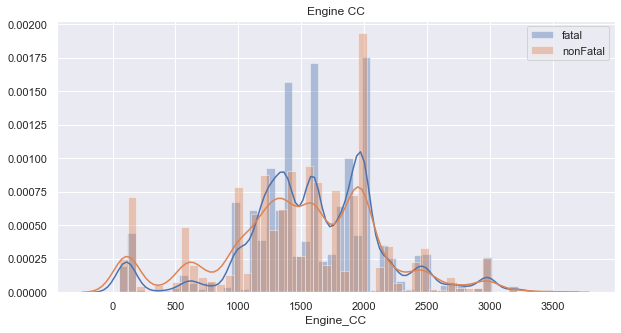

In [27]:
# engine cc and fatal/nonFatal
sns.set(rc={'figure.figsize':(10, 5)})
plt.title("Engine CC")
sns.distplot(fatal['Engine_CC'], label='fatal') 
sns.distplot(nonFatal['Engine_CC'], label='nonFatal')
plt.legend()
plt.show();

___

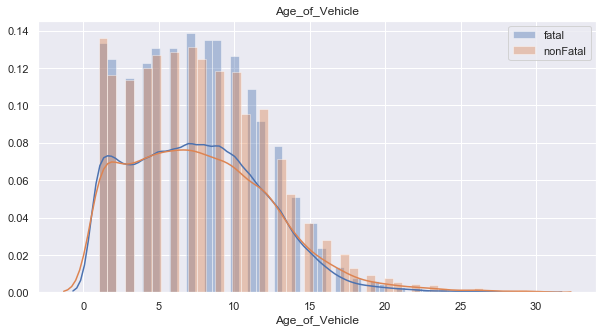

In [28]:
# age of vehicle
sns.set(rc={'figure.figsize':(10, 5)})
plt.title("Age_of_Vehicle")
sns.distplot(fatal['Age_of_Vehicle'], label='fatal') 
sns.distplot(nonFatal['Age_of_Vehicle'], label='nonFatal')
plt.legend()
plt.show();

In [29]:
df['Age_of_Vehicle'].value_counts(ascending=True).head(10)/len(df)

28    0.000239
30    0.000259
29    0.000339
27    0.000418
25    0.000518
26    0.000657
24    0.000896
23    0.001055
22    0.001673
21    0.002111
Name: Age_of_Vehicle, dtype: float64

In [30]:
# to eliminate age of vehicle outliers?- undecided
# df = df[df['Age_of_Vehicle'] < 25]

There does appear to be more fatal accidents correlated with lower engine ccs, though it's hard to say how significantly. There may be some mild outliers, I don't think I'll be cutting them at this point, though. Some models are more robust to them anyways.

___

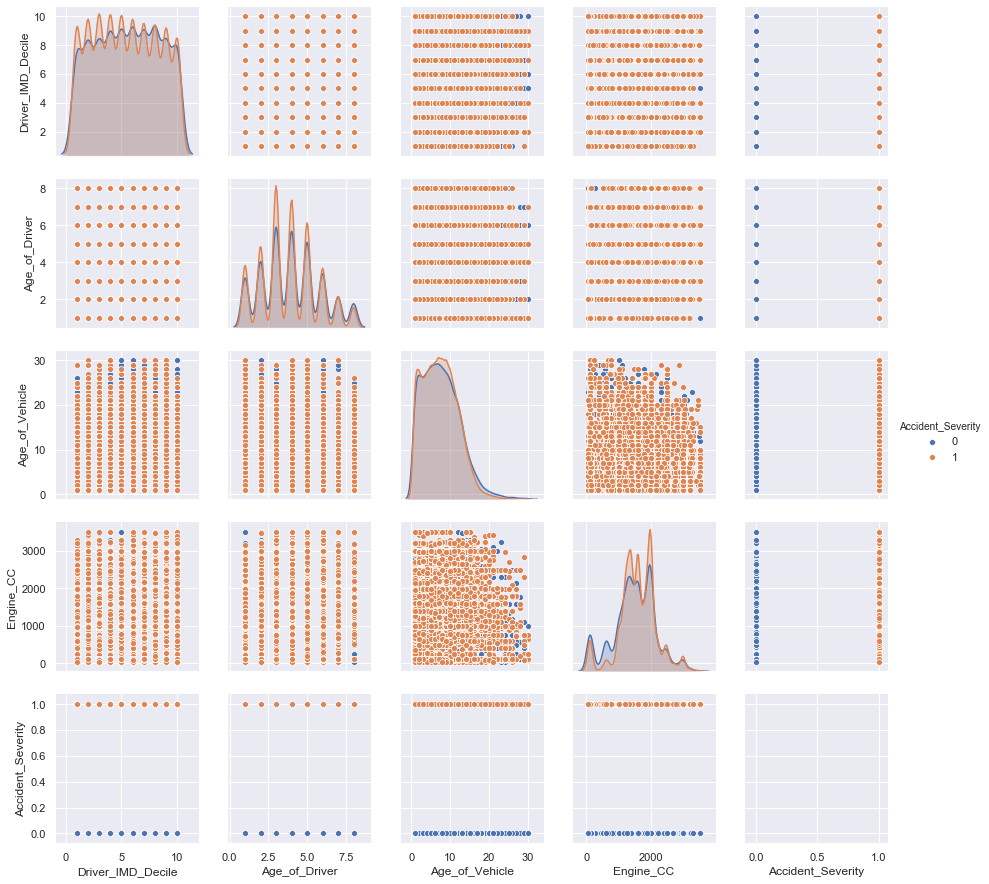

In [31]:
#distribution and relationships between variables
sns.pairplot(df, hue = 'Accident_Severity')

In [32]:
# # another way of looking at it(not as pretty)
# g = sns.PairGrid(df, hue="Accident_Severity")
# g.map_diag(sns.kdeplot)
# g.map_offdiag(sns.kdeplot);

### train test split & feature importance

To prep the data, I'll be separating the target and feature variables for train-test splitting. It's important not to let the train and test set be involved, as this would interfere with the performance of the models. I will also be transforming the feature variables to all be on the same scale as is necessary.

In [33]:
# #ignore
# #backup df
#sample_df = df.sample(frac=.2, random_state=3)
#df = df.sample(frac=.2, random_state=3)

In [34]:
# assign target accident severity
y = df["Accident_Severity"]

# assigning accident severity as seperate from further transformations
target = df['Accident_Severity']

#remove target from features
df.drop(columns= ['Accident_Severity'], axis=1, inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50215 entries, 15366 to 228451
Data columns (total 10 columns):
Region                    50215 non-null object
Urban_or_Rural_Area       50215 non-null object
Driver_IMD_Decile         50215 non-null int64
Age_of_Driver             50215 non-null int64
Age_of_Vehicle            50215 non-null int64
Driver_Journey_Purpose    50215 non-null object
Engine_CC                 50215 non-null int64
Propulsion_Code           50215 non-null object
Vehicle_Make              50215 non-null object
Vehicle_Category          50215 non-null object
dtypes: int64(4), object(6)
memory usage: 5.5+ MB


In [36]:
# dummy categorical features
col_list = list(df.select_dtypes(include=['object']).columns)

# create dummies for categorical features, assign to X
df = pd.DataFrame(pd.get_dummies(data=df,columns=col_list
                           , drop_first=True
                   , prefix=col_list))
X = df

Looking at feature importance using chi2. It may sometimes provide interesting insights that indicate that the data still needs some work before fitting to models or other useful things.

In [37]:
# using chi2 to look at feature importance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feats','Score']  #naming columns
print(featureScores.nlargest(10,'Score'))  #print best features

                          Feats         Score
3                     Engine_CC  63072.888269
39  Vehicle_Category_Motorcycle   1173.706808
38          Vehicle_Make_Yamaha    246.861283
5                 Region_London    235.587496
27           Vehicle_Make_Other    199.293729
12    Urban_or_Rural_Area_Urban    170.528301
33          Vehicle_Make_Suzuki    154.470945
19           Vehicle_Make_Honda     91.779395
2                Age_of_Vehicle     80.445537
1                 Age_of_Driver     49.206524


The engine_CC feature looks by far to be most important according to the chi2

In [38]:
## extraTrees classifier feature importance
# # using extratrees to look at feature importance
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt
# model = ExtraTreesClassifier()
# model.fit(X,y)
# print(model.feature_importances_) 
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh')
# plt.show()

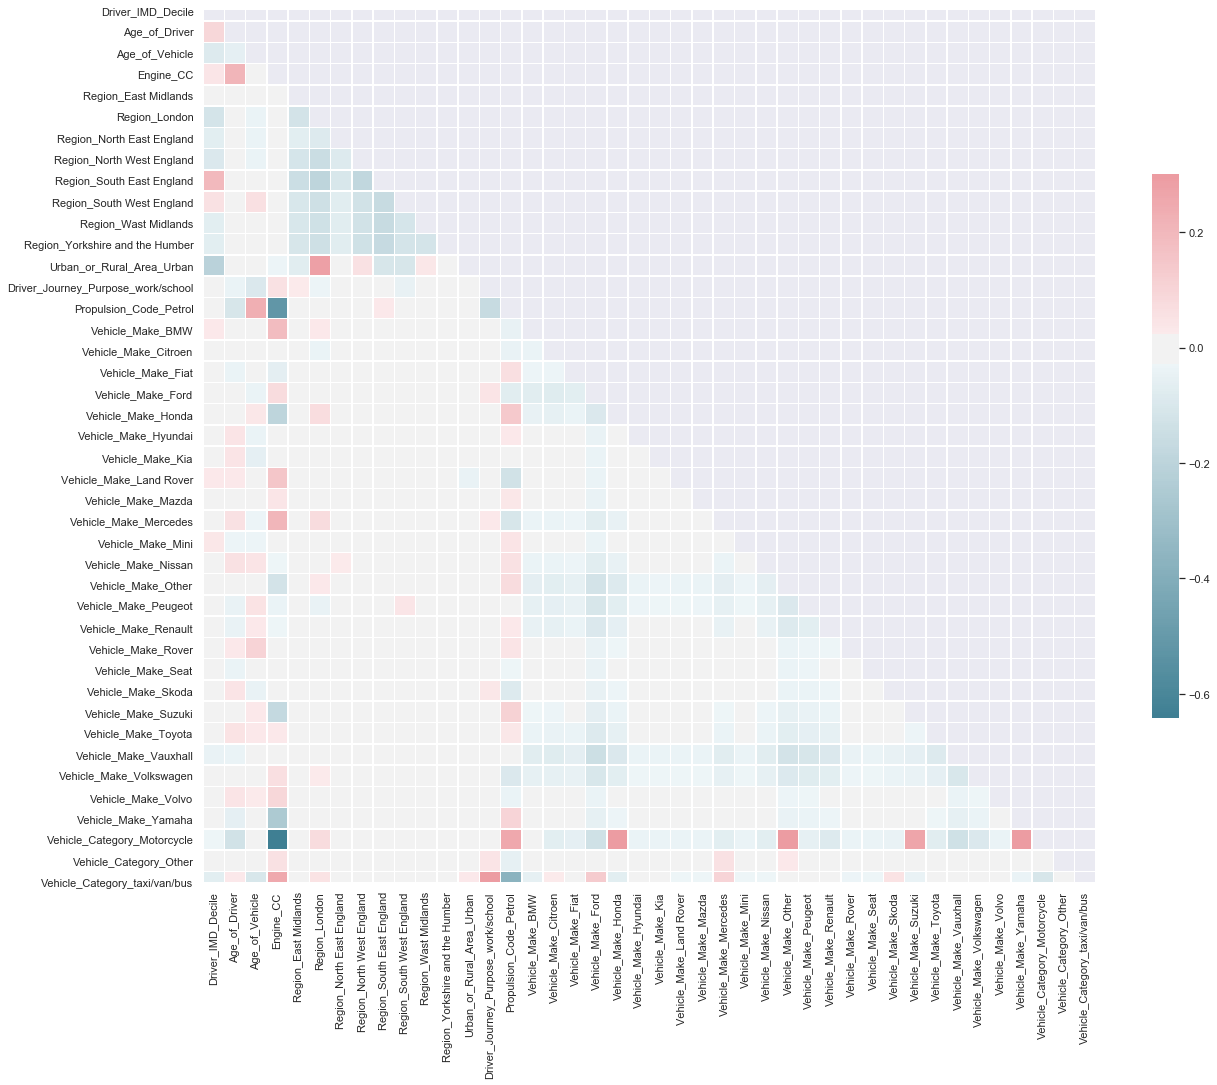

In [39]:
# correlation plot
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

strong negative correlations show between engine CC and motorcycles, as well at petrol and taxi/van/bus category

In [40]:
#train-test split 80%/20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=3)

In [41]:
# scale train and test features seperately
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

Most models will take care of the feature selection on it's own, but some perform better and/or faster, when reducing the dimensions. Using PCA is a way to do that and can be used in pipelines

In [42]:
#how many rows and features after the data prep
X.shape

(50215, 42)

In [43]:
# looking to keep enough to maintain 90% explained variance
pca = PCA(n_components=35)
principalComponents = pca.fit_transform(X_train)
print(np.sum(pca.explained_variance_ratio_))

num_feats = 36

0.9705495790566923


## Model fitting

In [44]:
#assign pipelines

pipe_tree = Pipeline([('dt_model', DecisionTreeClassifier(random_state=3))])

pipe_rf = Pipeline([('rf_model', RandomForestClassifier(random_state=3))])

pipe_ada = Pipeline([('ada_model', AdaBoostClassifier(random_state=3))])

pipe_gbt = Pipeline([('gbt_model', GradientBoostingClassifier(random_state=3))])

pipe_xgb = Pipeline([('xgb_model', XGBClassifier(random_state=3))])

pipe_svc = Pipeline([('svm_model', svm.SVC(random_state=3))])


___
For all models below, I will be following the same process:
1. Initialize and fit default model
2. Diagnostics of default model performance
3. Construct and perform random grid search
4. Construct and perform cross validation grid search with tighter parameters, based on the best parameters from the random grid search
5. Fit model according to the most accurate parameters from the CV grid search
6. Model report of tuned model, compare to default
7. Plot feature importance of tuned model.



## decision tree

Decision trees don't require preprocessing and handle non normal distributions of data as well as colinearity, but can be prone to outliers and overfitting. 

In [45]:
# initialize and fit default decision tree
dt_model = DecisionTreeClassifier(random_state=3)
dt_model.fit(X_train, y_train)

predictions = dt_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 99.63%
test score: 63.37%
cross val score: 63.42%
AUC  : 52.55%


Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.31      0.30      2534
           1       0.76      0.74      0.75      7509

   micro avg       0.63      0.63      0.63     10043
   macro avg       0.52      0.53      0.52     10043
weighted avg       0.64      0.63      0.64     10043


Confusion matrix:


,pred non,pred fatal
actual non,778,1756
actual fatal,1923,5586


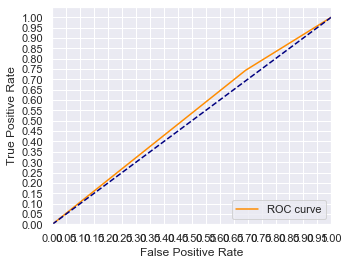

In [46]:
model_report(dt_model)

The default decision tree severely over fits, and has a poor accuracy score.

### random grid

In [47]:
print(dt_model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')


In [48]:
# set random search params
criterion=['gini','entropy']
max_leaf_nodes = [None,10,75,90,100,150,500]
# num feats
#max_features = ['auto', 'sqrt']
# max levels in tree
#max_depth = [int(x) for x in np.linspace(1, 100, num = 1)]
#max_depth.append(None)
# min samples required to split node
min_samples_split = [.1,2,3,4,5]
# min samples required at node
min_samples_leaf = [3,50,10,100,200,300]
# method of sampling
#bootstrap = [True, False]

random_grid = {'criterion':criterion,
               'max_leaf_nodes': max_leaf_nodes,
               #'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

In [49]:
# random grid search
# cv: number of folds
# n_iter: number of combinations
dt_random = RandomizedSearchCV(estimator = dt_model
                               , param_distributions = random_grid
                               , n_iter = 100, cv = 5, verbose=1, error_score=0
                               , scoring=('accuracy')
                               , random_state=3, n_jobs = -1)
# fit random search model
dt_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.0min finished


RandomizedSearchCV(cv=5, error_score=0,
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [None, 10, 75, 90, 100, 150, 500], 'min_samples_split': [0.1, 2, 3, 4, 5], 'min_samples_leaf': [3, 50, 10, 100, 200, 300]},
          pre_dispatch='2*n_jobs', random_state=3, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=1)

In [50]:
dt_random.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 100,
 'max_leaf_nodes': 10,
 'criterion': 'entropy'}

### cross val grid search

In [51]:
# grid search params
param_grid_dt = [
    {'dt_model__criterion': ['entropy','gini'],
    #'dt_model__max_depth': [None,2,3],
    'dt_model__min_samples_split': [.1,2,3,5,6],
    'dt_model__min_samples_leaf': [90,100,170],
    # ,'dt_model__max_features':['auto', 'sqrt'],
     'dt_model__max_leaf_nodes':[9,10,15]
     
    }
]

# grid search
gs_dt = GridSearchCV(estimator=pipe_tree,
                    param_grid=param_grid_dt,
                     error_score=0,
                    scoring=('accuracy'),
                    cv=5, n_jobs=-1, verbose=2)

# fitting grid search
gs_dt.fit(X_train, y_train)

# best parameters
print('Best score: {:.3}%'.format(gs_dt.best_score_ * 100))
print('params:\n', gs_dt.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   35.1s finished


Best score: 75.9%
params:
 {'dt_model__criterion': 'gini', 'dt_model__max_leaf_nodes': 100, 'dt_model__min_samples_leaf': 170, 'dt_model__min_samples_split': 2}


In [52]:
# using best params to fit model
dt_gs_model = DecisionTreeClassifier(criterion='gini',
                             # max_depth=3,
                             # max_features='auto',
                              max_leaf_nodes= 74,
                                    # 97,
                               min_samples_leaf=175,
                                    # 40,
                               min_samples_split=2
                                    # 0.1
                                
                                    )
dt_gs_model.fit(X_train, y_train)

predictions = dt_gs_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 76.16%
test score: 75.86%
cross val score: 75.99%
AUC  : 54.37%


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.11      0.19      2534
           1       0.76      0.98      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.69      0.54      0.52     10043
weighted avg       0.73      0.76      0.69     10043


Confusion matrix:


,pred non,pred fatal
actual non,278,2256
actual fatal,168,7341


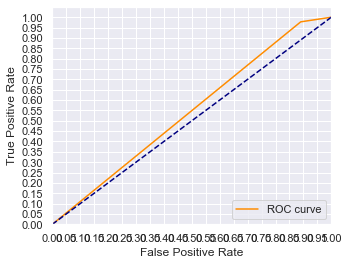

In [53]:
# new model report
model_report(dt_gs_model)

In [ ]:
# ##default model:
# Cross Validation Scoring:

# train score: 99.63%, 
# test score: 63.37%, 
# cross val score: 63.42%, 
# AUC  : 52.55%


# Classification Report:
#               precision    recall  f1-score   support

#            0       0.29      0.31      0.30      2534
#            1       0.76      0.74      0.75      7509

# weighted avg       0.64      0.63      0.64     10043

train test score rose from 63.37% to 75.86%

cross validation went from 63.42% to 75.99%

auc score from 52.55% to 54.37%

Fatal recall dropped

After tuning, the model is more robust, but the recall for fatal accidents dropped much more than ideal. We could adjust the model to a fit that prioritizes the recall, but will focus on accuracy for now.

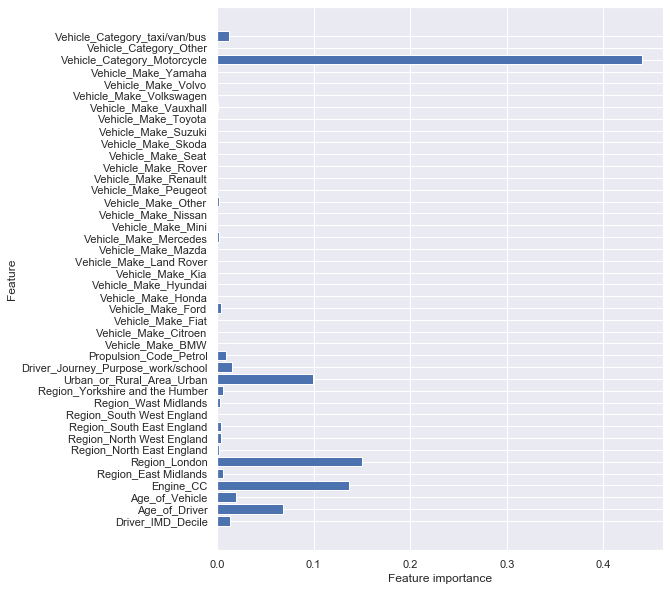

In [54]:
# most important features to tuned model
plot_feats(dt_gs_model)

Motorcycle, London, Urban, and Engine CC appear to be most important for the decision tree model. Let's see if this is consistent with other models, and it we can improve the scores.

## random Forest

Random forest is a collection of decision trees, and will be less prone to overfitting, more robust and usually more accurate than a decision tree. It's also much less time consuming than some other models.

In [55]:
#initialize and fit random forest
rf_model = RandomForestClassifier(random_state=3)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 98.49%
test score: 70.33%
cross val score: 69.96%
AUC  : 54.76%


Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.23      0.28      2534
           1       0.77      0.86      0.81      7509

   micro avg       0.70      0.70      0.70     10043
   macro avg       0.57      0.55      0.55     10043
weighted avg       0.67      0.70      0.68     10043


Confusion matrix:


,pred non,pred fatal
actual non,591,1943
actual fatal,1037,6472


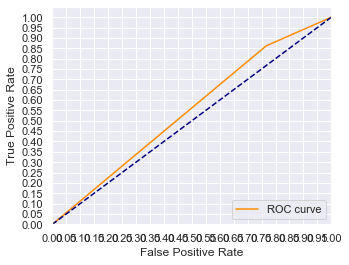

In [56]:
model_report(rf_model)

### random Search

In [57]:
print(rf_model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=3, verbose=0, warm_start=False)


In [58]:
# set random search params
# no of trees
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 0.01,0.1,3,10,100,300]
# Minimum number of samples required at each leaf node
min_samples_leaf = [.01,3, 10,50,100,300]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#pprint(random_grid)

In [59]:
# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model
                               , param_distributions = random_grid
                               , n_iter = 20, cv = 3, verbose=2
                               , random_state=3, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=3, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [1, 125, 250, 375, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, None], 'min_samples_split': [0.01, 0.1, 3, 10, 100, 300], 'min_samples_leaf': [0.01, 3, 10, 50, 100, 300], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=3, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [60]:
rf_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 100,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

### cross val grid search

In [61]:
# grid search params
param_grid_rf = [
    {'rf_model__criterion': ['entropy','gini'],
    'rf_model__n_estimators': [100,250,300],
    #'rf_model__max_depth': [None],
    'rf_model__min_samples_split': [2,100,120],
    'rf_model__min_samples_leaf': [5,10,15],
     #'rf_model__max_features':['auto', 'sqrt'],
     'rf_model__bootstrap':[False, True]
    }
]

# grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
                    param_grid=param_grid_rf,
                    scoring='accuracy',
                    cv=3, n_jobs=-1, verbose=2)

# fitting grid search
gs_rf.fit(X_train, y_train)

# best parameters
print('best accuracy: {:.4}%'.format(gs_rf.best_score_ * 100))
print('params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 22.3min finished


best accuracy: 76.1%
params:
 {'rf_model__bootstrap': True, 'rf_model__criterion': 'entropy', 'rf_model__min_samples_leaf': 5, 'rf_model__min_samples_split': 120, 'rf_model__n_estimators': 250}


In [62]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(criterion='entropy'
                                 , max_depth=None
                                 , min_samples_leaf=5
                                 , min_samples_split=120
                                 , n_estimators=250
                                 #, max_features= 'auto'
                                 , bootstrap= True
                                    )
rf_gs_model.fit(X_train, y_train)

predictions = rf_gs_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 76.03%
test score: 75.63%
cross val score: 75.83%
AUC  : 52.68%


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.06      0.12      2534
           1       0.76      0.99      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.72      0.53      0.49     10043
weighted avg       0.74      0.76      0.67     10043


Confusion matrix:


,pred non,pred fatal
actual non,161,2373
actual fatal,74,7435


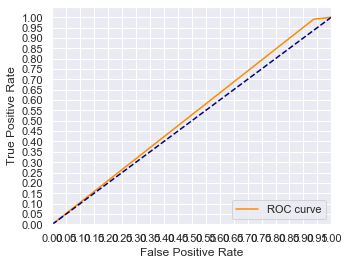

In [63]:
# new model report
model_report(rf_gs_model)

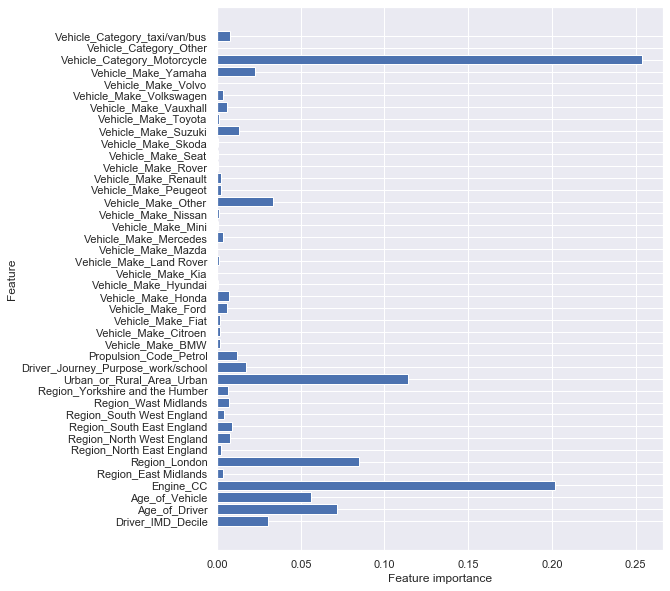

In [64]:
plot_feats(rf_gs_model)

In this model, motorcyles, engine ccs, and cars appear most important.

## adaboost

In [65]:
#initialize and fit default model
ada_model = AdaBoostClassifier(random_state=3)
ada_model.fit(X_train, y_train)

predictions = ada_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 76.15%
test score: 75.81%
cross val score: 76.06%
AUC  : 54.14%


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.10      0.18      2534
           1       0.76      0.98      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.69      0.54      0.52     10043
weighted avg       0.73      0.76      0.69     10043


Confusion matrix:


,pred non,pred fatal
actual non,263,2271
actual fatal,158,7351


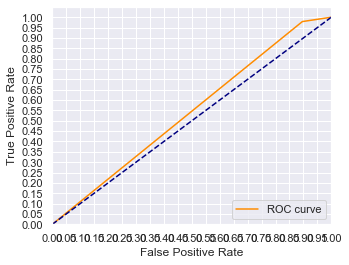

In [66]:
#baseline model report
model_report(ada_model)

In [67]:
print(ada_model)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=3)


### random search

In [68]:
#set random search params
learning_rate= [.00001,.001,.01,.1,1, 1.5]

n_estimators = [1,5,10,50,100, 200]

random_grid = {'learning_rate':learning_rate,
               'n_estimators': n_estimators
              }

In [69]:
#random grid search
ada_random = RandomizedSearchCV(estimator = ada_model
                               , param_distributions = random_grid
                               , n_iter = 50, cv = 3, verbose=2
                               , random_state=3, n_jobs = -1)
# Fit the random search model
ada_random.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=3),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'learning_rate': [1e-05, 0.001, 0.01, 0.1, 1, 1.5], 'n_estimators': [1, 5, 10, 50, 100, 200]},
          pre_dispatch='2*n_jobs', random_state=3, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [70]:
ada_random.best_params_

{'n_estimators': 50, 'learning_rate': 1.5}

### cross val grid search

In [71]:
#grid search params and fitting grid search
param_grid_ada = [
    {'ada_model__n_estimators': [9,10,11,12,50,60,100],
    'ada_model__learning_rate': [.9,1,1.1,1.5]}
]

# Construct Grid Search
gs_ada = GridSearchCV(estimator=pipe_ada,
                    param_grid=param_grid_ada,
                    scoring='accuracy',
                    cv=3, n_jobs=-1, verbose=1)

# Fit using grid search
gs_ada.fit(X_train, y_train)

# Best accuracy and parameters
print('best recall: {:.4}%'.format(gs_ada.best_score_ * 100))
print('params:\n', gs_ada.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   30.9s finished


best recall: 76.13%
params:
 {'ada_model__learning_rate': 1.1, 'ada_model__n_estimators': 100}


In [72]:
# fit best params
ada_gs_model = AdaBoostClassifier(n_estimators=100,
                                   learning_rate=1.1)
ada_gs_model.fit(X_train, y_train)

predictions = ada_gs_model.predict(X_test)
actuals = y_test



Cross Validation Scoring:

train score: 76.11%
test score: 75.81%
cross val score: 76.01%
AUC  : 54.71%


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.12      0.20      2534
           1       0.77      0.97      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.68      0.55      0.53     10043
weighted avg       0.73      0.76      0.69     10043


Confusion matrix:


,pred non,pred fatal
actual non,307,2227
actual fatal,202,7307


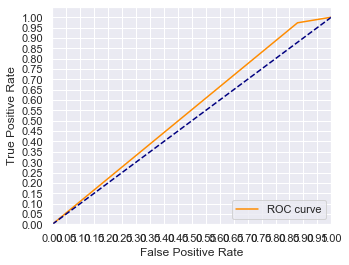

In [73]:
model_report(ada_gs_model)

While the cross validation score slightly improved, the test score on the default model was actually better than the tuned one. 

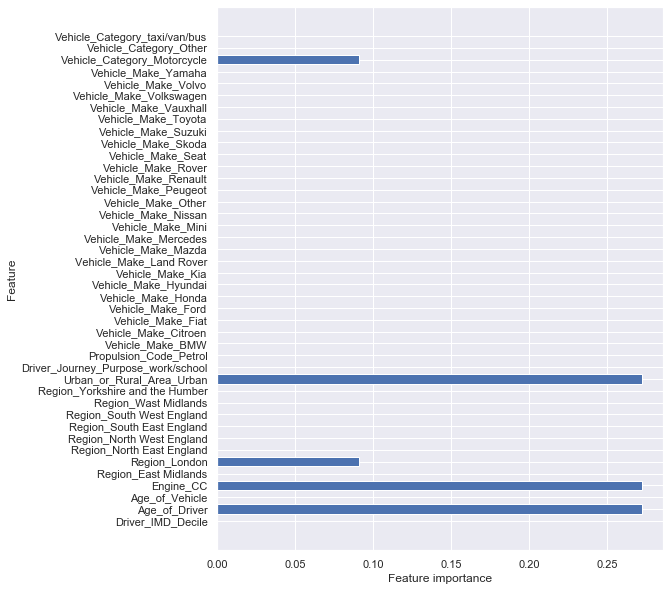

In [74]:
plot_feats(ada_gs_model)

## gradient boost 

Gradient boost is one of the models that takes much longer to grid search and fit than others.

In [75]:
#initialize and fit gradient boost
gbt_model = GradientBoostingClassifier(random_state=3)
gbt_model.fit(X_train, y_train)

predictions = gbt_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 76.34%
test score: 75.87%
cross val score: 75.99%
AUC  : 54.41%


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.11      0.19      2534
           1       0.77      0.98      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.69      0.54      0.52     10043
weighted avg       0.73      0.76      0.69     10043


Confusion matrix:


,pred non,pred fatal
actual non,281,2253
actual fatal,170,7339


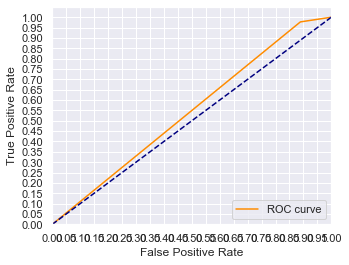

In [76]:
#baseline model report
model_report(gbt_model)

### random search

In [77]:
print(gbt_model)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=3,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [78]:
# setting parameters for random search
learning_rate=[.1]
#
loss = ['deviance', 'exponential']
# 
max_depth = [None,2,3,4]
#m
# 
n_estimators = [50,100,200]
# 
min_samples_split = [2,3,4]
#
min_samples_leaf = [1,2,3]
# Create the random grid
min_weight_fraction_leaf = [0,0.0001, 0.001]
random_grid = {'learning_rate':learning_rate,
               'loss': loss,
               'max_depth': max_depth,
               'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_weight_fraction_leaf': min_weight_fraction_leaf
               
              }
#pprint(random_grid)

In [79]:
#searching random params
gbt_random = RandomizedSearchCV(estimator = gbt_model
                               , param_distributions = random_grid
                               , n_iter = 20, cv = 3, verbose=2
                               , random_state=3, n_jobs = -1)
# fit random search model
gbt_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 37.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'learning_rate': [0.1], 'loss': ['deviance', 'exponential'], 'max_depth': [None, 2, 3, 4], 'n_estimators': [50, 100, 200], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'min_weight_fraction_leaf': [0, 0.0001, 0.001]},
          pre_dispatch='2*n_jobs', random_state=3, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [80]:
gbt_random.best_params_

{'n_estimators': 50,
 'min_weight_fraction_leaf': 0.0001,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 3,
 'loss': 'deviance',
 'learning_rate': 0.1}

### cross val search

In [81]:
# grid search params and run search
param_grid_gbt = [
    {'gbt_model__n_estimators': [40,60,100,120],
     'gbt_model__min_weight_fraction_leaf':[0.001, 0.01, 0.0001],
    'gbt_model__learning_rate': [0.1, .001],
    'gbt_model__min_samples_split': [2,3,4],
    'gbt_model__min_samples_leaf': [2,3,5,6],
    'gbt_model__max_depth': [2,3]
    }
]

# grid search
gs_gbt = GridSearchCV(estimator=pipe_gbt,
                    param_grid=param_grid_gbt,
                    scoring='accuracy',
                    cv=3, n_jobs=-1, verbose=1)

# fit grid search
gs_gbt.fit(X_train, y_train)

# best params
print('best accuracy: {:.4}%'.format(gs_gbt.best_score_ * 100))
print('params:\n', gs_gbt.best_params_)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 91.9min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 206.7min finished


best accuracy: 76.15%
params:
 {'gbt_model__learning_rate': 0.1, 'gbt_model__max_depth': 2, 'gbt_model__min_samples_leaf': 2, 'gbt_model__min_samples_split': 2, 'gbt_model__min_weight_fraction_leaf': 0.01, 'gbt_model__n_estimators': 100}


In [82]:
# fitting best params
gbt_gs_model = GradientBoostingClassifier(learning_rate=0.1,
                                         max_depth=2,
                                         min_samples_leaf=2,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.01,
                                         n_estimators=60)
gbt_gs_model.fit(X_train, y_train)

predictions = gbt_gs_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 76.09%
test score: 75.73%
cross val score: 76.0%
AUC  : 53.77%


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.09      0.16      2534
           1       0.76      0.98      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.69      0.54      0.51     10043
weighted avg       0.73      0.76      0.68     10043


Confusion matrix:


,pred non,pred fatal
actual non,239,2295
actual fatal,142,7367


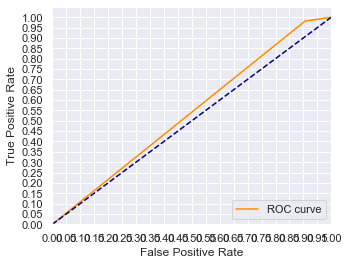

In [83]:
# new model report
model_report(gbt_gs_model)

Very little improvement was seen between the default and tuned model. In fact, the cross validation didn't show any improvement, and the train accuracy only .01%.  This 

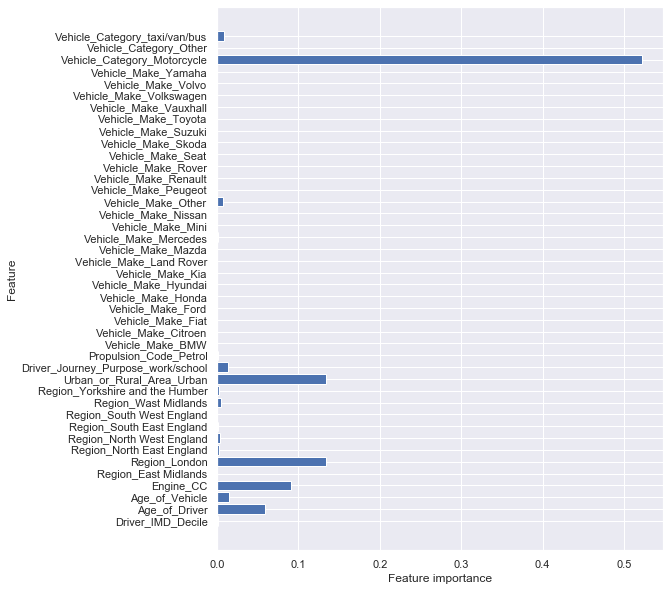

In [84]:
plot_feats(gbt_gs_model)

## XGBoost

In [85]:
# initiate model
xgb_model = XGBClassifier(random_state=3)
xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 76.28%
test score: 75.86%
cross val score: 76.04%
AUC  : 54.31%


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.11      0.18      2534
           1       0.76      0.98      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.70      0.54      0.52     10043
weighted avg       0.73      0.76      0.69     10043


Confusion matrix:


,pred non,pred fatal
actual non,274,2260
actual fatal,164,7345


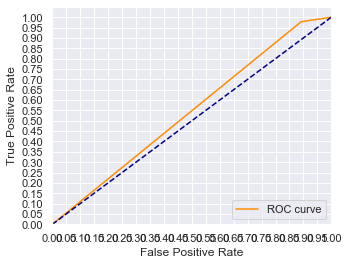

In [86]:
model_report(xgb_model)

In [87]:
print(xgb_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=3, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


### random grid

In [88]:
#set random search params
learning_rate=[.01, .1, .2, 1]
# 
max_depth = [2,3,6,10]
#max_depth.append(None)
min_child_weight = [0,1,2]
#
n_estimators = [50,100,200,300]
# Create the random grid
#min_weight_fraction_leaf = [0,0.0001, 0.01, 1]
random_grid = {
               'learning_rate':learning_rate,
               'max_depth': max_depth,
               'min_child_weight':min_child_weight,
               'n_estimators': n_estimators
               
              }
#pprint(random_grid)

In [89]:
# searching random params
xgb_random = RandomizedSearchCV(estimator = xgb_model
                               , param_distributions = random_grid
                               , n_iter = 20, cv = 3, verbose=1
                               , random_state=3, n_jobs = -1)
# fit random search model
xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 36.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=3, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.1, 0.2, 1], 'max_depth': [2, 3, 6, 10], 'min_child_weight': [0, 1, 2], 'n_estimators': [50, 100, 200, 300]},
          pre_dispatch='2*n_jobs', random_state=3, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [90]:
xgb_random.best_params_

{'n_estimators': 50,
 'min_child_weight': 0,
 'max_depth': 3,
 'learning_rate': 0.2}

### cross val grid

In [91]:
param_grid_xgb = [
    {
#         'xgb_model__min_samples_split':[2,3],
      #   'xbg_model__gamma':[0.01,0.1,.05],
        'xgb_model__min_child_weight': [1,.1,.01],
    'xgb_model__learning_rate': [0.001,0.01],
    'xgb_model__n_estimators': [150,200,250],
    'xgb_model__max_depth': [2,3]}
]

# Construct Grid Search
gs_xgb = GridSearchCV(estimator=pipe_xgb,
                    param_grid=param_grid_xgb,
                    scoring='accuracy',
                    cv=3, n_jobs=-1, verbose=1)

# Fit using grid search
gs_xgb.fit(X, y)

# Best accuracy and parameters
print('best score: {:.3}%'.format(gs_xgb.best_score_ * 100))
print('params:\n', gs_xgb.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 64.3min finished


best score: 76.0%
params:
 {'xgb_model__learning_rate': 0.001, 'xgb_model__max_depth': 3, 'xgb_model__min_child_weight': 1, 'xgb_model__n_estimators': 150}


In [92]:
xgb_gs_model = XGBClassifier(learning_rate=0.001,
                             max_depth=3,
                             min_child_weight=1,
                             n_estimators=150)
xgb_gs_model.fit(X_train, y_train)

predictions = xgb_gs_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 76.1%
test score: 75.79%
cross val score: 76.02%
AUC  : 54.75%


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.12      0.20      2534
           1       0.77      0.97      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.68      0.55      0.53     10043
weighted avg       0.72      0.76      0.69     10043


Confusion matrix:


,pred non,pred fatal
actual non,311,2223
actual fatal,208,7301


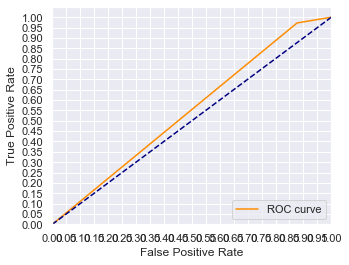

In [93]:
model_report(xgb_gs_model)

The cross validation and weighted recall scored higher, but the recall for fatal is lower for the tuned model.

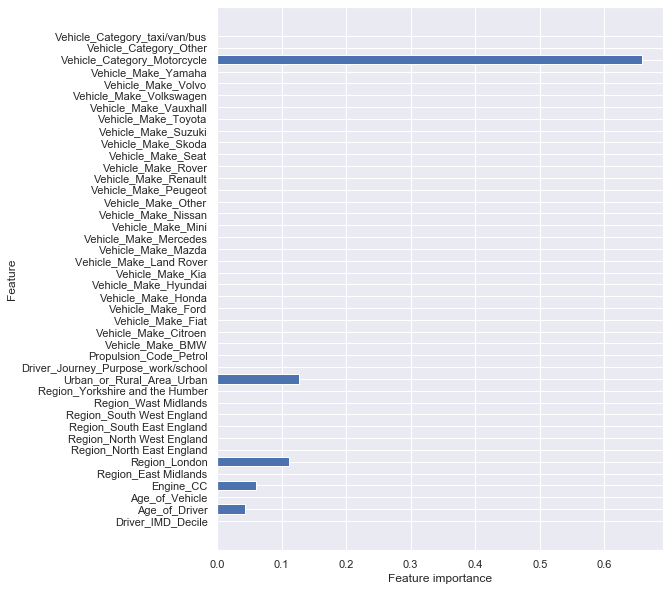

In [94]:
plot_feats(xgb_gs_model)

## SVC

SVM uses kernel trick, deals well with colinearity, and is better for categorical data. It may not always be worth the extra time it takes, though.

In [95]:
svm_model = svm.SVC(random_state=3)
svm_model.fit(X_train, y_train)

predictions = svm_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 76.34%
test score: 75.67%
cross val score: 75.52%
AUC  : 53.89%


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.10      0.17      2534
           1       0.76      0.98      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.69      0.54      0.51     10043
weighted avg       0.72      0.76      0.68     10043


Confusion matrix:


,pred non,pred fatal
actual non,251,2283
actual fatal,160,7349


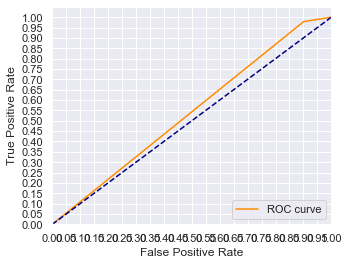

In [96]:
model_report(svm_model)

In [97]:
print(svm_model)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=3,
  shrinking=True, tol=0.001, verbose=False)


### random search

In [98]:
# set random search params

clf_C = [0.001, 0.01,.1,1.]
# min samples required at node
clf_gamma = [.001,.01,1.]
# method of sampling
clf_kernel = ['rbf', 'linear']

random_grid = {
               'C': clf_C,
               'gamma': clf_gamma,
              # 'kernel': clf_kernel
               }

In [100]:
# # fit and search random param combinations
# svm_random = RandomizedSearchCV(estimator = svm_model
#                                , param_distributions = random_grid
#                                , n_iter = 10, cv = 3, verbose=2
#                                , random_state=3, n_jobs = -1)
# # Fit the random search model
# svm_random.fit(X_train, y_train)

In [ ]:
svm_random.best_params_

### cross val grid search

In [102]:
# Construct pipeline for support vector grid search

pipe_svm = Pipeline([('pca', PCA(n_components=num_feats)),
            ('clf', svm.SVC(random_state=3))])

# Set grid search params
param_grid_svm = [
 
  {'clf__C': [.001,0.1, 1], 'clf__gamma': [0.1, 0.01, 0.001], 'clf__kernel': ['rbf']},
 ]

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='recall',
            cv=3, verbose=1, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('Best score: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

In [103]:
svm_gs_model = svm.SVC(C=1
                       ,gamma=0.01
                            ,kernel='rbf'
                             )
svm_gs_model.fit(X_train, y_train)

predictions = svm_gs_model.predict(X_test)
actuals = y_test


Cross Validation Scoring:

train score: 76.19%
test score: 75.92%
cross val score: 75.42%
AUC  : 54.18%


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.10      0.18      2534
           1       0.76      0.98      0.86      7509

   micro avg       0.76      0.76      0.76     10043
   macro avg       0.70      0.54      0.52     10043
weighted avg       0.73      0.76      0.69     10043


Confusion matrix:


,pred non,pred fatal
actual non,261,2273
actual fatal,145,7364


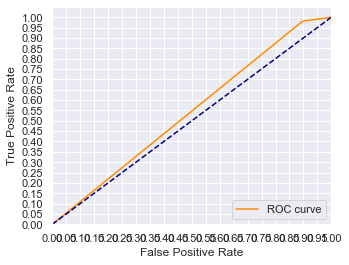

In [104]:
model_report(svm_gs_model)

In [ ]:
plot_feats(svm_gs_model)

## conclusion

While I was able to increase the accuracy of the models, the recall rate always went down with fine tuning. It's possible to increase the recall rate if that was the goal, though, and it may be something to come back to in the future. 

Resampling the dataset to have even fatal and non fatal accidents might be a way to improve the models.
